# Logistic Regression

This section mentions how to train a model to classify handwritten digits. We will use the famous [MNIST handwritten digit database](http://yann.lecun.com/exdb/mnist/) as our training dataset. It consists of 28 x 28 pixels grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. The trained model is save to file after the training process.

Here are some sample images from the dataset:
![MNIST sample](images/mnist_samples.png)

<center>
    (image source: <a href="https://www.researchgate.net/publication/306056875_An_analysis_of_image_storage_systems_for_scalable_training_of_deep_neural_networks">researchgate.net</a>)
</center>

> We suppose that there'are linear lines separating digit groups.

The workflow is presented in the figure below.

![workflow](images/logistic_regression.svg)

## Import libraries

In [25]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

## 1. Prepare data

### 1.1 Convert train & test images to tensors

In [26]:
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

### 1.2 Split train images to train & validation sets

In [27]:
data_size = len(dataset)
train_size = round(data_size*0.8)
val_size = data_size - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

### 1.3 Define batch size & dataloaders

In [28]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

## 2. Create model

In [29]:
class MnistModel(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.linear = nn.Linear(in_features, out_classes)
    
    def forward(self, X:torch.tensor) -> torch.tensor:
        """Compute linear prediction of image(s)
        
        Args:
            X (tensor.torch): input image(s)
        
        Returns:
            tensor.torch: linear prediction of image(s)
        """
        X = X.reshape(-1, self.linear.in_features)
        Y_linear = self.linear(X)
        return Y_linear
    
    def predict(self, X:torch.tensor) -> torch.tensor:
        """Predict class(es) of image(s)
        
        Args:
            X (tensor.torch): input image(s)
        
        Returns:
            tensor.torch: class(es) predicted
        """
        Y_linear = self(X)
        probs = F.softmax(Y_linear.detach(), dim=1)
        _, Y_hat = torch.max(probs, dim=1)
        return Y_hat
    
    def cost_func(self, batch:list) -> torch.tensor:
        """Compute cost of predictions
        
        Args:
            batch (list): containing 2 items: images & labels
            
        Returns:
            tensor.torch: the cost
        """
        images, labels = batch
        Y_linear = self(images)
        cost = F.cross_entropy(Y_linear, labels)
        return cost
    
    def evaluate(self, batch:list) -> dict:
        """Compute cost & accuracy of predictions
        
        Args:
            batch (list): containing 2 items: images & labels
        
        Returns:
            dict: containing 2 keys: cost & accuracy
        """
        images, labels = batch
        Y_hat = self.predict(images)
        acc = torch.sum(Y_hat == labels).item()/len(Y_hat)
        Y_linear = self(images)
        cost = F.cross_entropy(Y_linear.detach(), labels).item()
        res = {
            'cost': cost,
            'accuracy': acc
        }
        return res

In [30]:
in_features = 28*28  # flat an image to a vector
out_classes = 10  # there'are 10 classes of digits
model = MnistModel(in_features, out_classes)

## 3. Define optimizer

In [31]:
lr = 1e-1  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr)

## 4. Train model

In [32]:
def evaluateEpoch(batch_evals:list, decimals=2) -> dict:
    """Get cost & accuracy of an epoch prediction
    
    Args:
        batch_evals (list): list of batch evaluation
        decimals (int, optional): decimals to round values
    
    Returns:
        dict: containing 2 keys: cost & accuracy
    """
    batch_costs = [x['cost'] for x in batch_evals]
    batch_accs = [x['accuracy'] for x in batch_evals]    
    cost = sum(batch_costs)/len(batch_costs)
    acc = sum(batch_accs)/len(batch_accs)
    res = {
        'cost': round(cost, decimals),
        'accuracy': round(acc, decimals)
    }
    return res

In [33]:
def fit(epochs:int, model:MnistModel, optimizer:torch.optim,
        train_loader:DataLoader, val_loader:DataLoader) -> list:
    """Train model
    
    Args:
        epochs (int): number of iterations
        model (MnistModel): model to train
        optimizer (torch.optim): function to optimize model parameters
        train_loader (DataLoader): data loader for training phase
        val_loader (DataLoader): data loader for validation phase
        
    Returns:
        list: evaluation results of epochs
    """
    logs = list()
    for i in range(epochs):
        # training phase
        for batch in train_loader:
            cost = model.cost_func(batch)  # compute cost
            cost.backward()  # compute gradients
            optimizer.step()  # adjust parameters
            optimizer.zero_grad()  # reset gradients to zero
        
        # validation phase
        batch_evals = [model.evaluate(batch) for batch in val_loader]
        res = evaluateEpoch(batch_evals)
        logs.append(res)
        print("epoch {}: validation cost = {}, validation accuracy = {}".format(
              i+1, res['cost'], res['accuracy']))
    return logs

In [34]:
epochs = 10
logs = fit(epochs, model, optimizer, train_loader, val_loader)

epoch 1: validation cost = 0.41, validation accuracy = 0.89
epoch 2: validation cost = 0.36, validation accuracy = 0.9
epoch 3: validation cost = 0.34, validation accuracy = 0.91
epoch 4: validation cost = 0.33, validation accuracy = 0.91
epoch 5: validation cost = 0.32, validation accuracy = 0.91
epoch 6: validation cost = 0.31, validation accuracy = 0.91
epoch 7: validation cost = 0.3, validation accuracy = 0.91
epoch 8: validation cost = 0.3, validation accuracy = 0.92
epoch 9: validation cost = 0.3, validation accuracy = 0.92
epoch 10: validation cost = 0.3, validation accuracy = 0.92


### 4.1 Evaluations on validation set

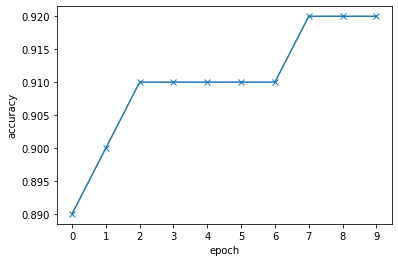

In [35]:
accuracies = [log['accuracy'] for log in logs]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xticks(range(epochs))
plt.show();

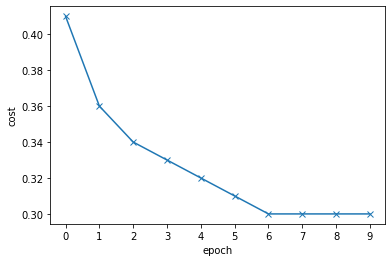

In [36]:
costs = [log['cost'] for log in logs]
plt.plot(costs, '-x')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.xticks(range(epochs))
plt.show();

### 4.2 Predict on test set

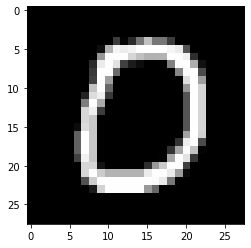

In [37]:
img, label = test_ds[10]
plt.imshow(img[0], cmap='gray');

In [38]:
y_hat = model.predict(img)
print('Label: {}, Predicted: {}'.format(label, y_hat.item()))

Label: 0, Predicted: 0


In [39]:
type(img), type(y_hat)

(torch.Tensor, torch.Tensor)

### 4.3 Evaluation on test set

In [40]:
batch_evals = [model.evaluate(batch) for batch in test_loader]
res = evaluateEpoch(batch_evals)
print('test cost = {}, test accuracy = {}'.format(res['cost'], res['accuracy']))

test cost = 0.29, test accuracy = 0.92


## 5. Save model

In [41]:
filename = 'mnist-logistic.pth'
torch.save(model.state_dict(), filename)

In [42]:
# initialize a new model
model2 = MnistModel(in_features, out_classes)
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-2.9883e-05,  2.7532e-02,  1.0665e-03,  ..., -1.0763e-02,
                       -1.5420e-02, -2.7935e-02],
                      [ 1.2817e-02, -4.6979e-03,  1.2590e-02,  ..., -2.9658e-02,
                        3.1874e-02,  2.7761e-02],
                      [-2.7293e-02,  2.1336e-03, -1.7714e-02,  ...,  2.8113e-02,
                        1.0875e-02, -1.3198e-02],
                      ...,
                      [-1.7033e-02, -1.3232e-03,  1.9284e-02,  ...,  2.5749e-02,
                        7.7961e-04, -1.4659e-02],
                      [-9.4601e-03,  2.7917e-02, -9.2593e-03,  ..., -2.0989e-02,
                        2.7739e-02,  4.0610e-03],
                      [-2.1058e-02, -9.0211e-03,  3.5213e-03,  ..., -3.3750e-02,
                       -1.9250e-02,  1.4850e-02]])),
             ('linear.bias',
              tensor([ 0.0349,  0.0312, -0.0303,  0.0158, -0.0307,  0.0354,  0.0270, -0.0105,
                      -0.0187,

In [43]:
# load model from file
model2.load_state_dict(torch.load(filename))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0076,  0.0155, -0.0013,  ...,  0.0331, -0.0210, -0.0128],
                      [-0.0228, -0.0172,  0.0255,  ...,  0.0049,  0.0296, -0.0177],
                      [ 0.0066,  0.0129, -0.0094,  ...,  0.0150, -0.0258,  0.0023],
                      ...,
                      [-0.0194, -0.0288,  0.0313,  ...,  0.0292,  0.0348,  0.0292],
                      [-0.0119, -0.0013,  0.0166,  ..., -0.0252,  0.0344,  0.0294],
                      [-0.0281,  0.0187, -0.0003,  ..., -0.0234,  0.0160, -0.0102]])),
             ('linear.bias',
              tensor([-0.3042,  0.3386,  0.0760, -0.2578,  0.0332,  1.0499, -0.0520,  0.4648,
                      -1.2268, -0.1823]))])